In [10]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

%matplotlib inline

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

from collections import Counter
from nltk import ngrams

In [2]:
# Read your api key environment variable
load_dotenv()
api_key = os.getenv("NEWS_API")

# Create newsapi client
from newsapi import NewsApiClient

newsapi = NewsApiClient(api_key=api_key)

In [3]:
# Fetching cloud news articles
cloud_headlines = newsapi.get_everything(
    q="cloud",
    language="en",
    sort_by="relevancy",
)

In [4]:
sentiments = []

for articles in cloud_headlines["articles"]:
    try:
        text = articles["content"]
        results = analyzer.polarity_scores(text)
        compound = results["compound"]
        pos = results["pos"]
        neu = results["neu"]
        neg = results["neg"]

        sentiments.append({
            "text": text,
            "Compound": compound,
            "Positive": pos,
            "Negative": neg,
            "Neutral": neu,
        })
    except AttributeError: # if there is an error pass
        pass
    
cloud  = pd.DataFrame(sentiments)
cloud.head()

,text,Compound,Positive,Negative,Neutral
0,"Microsoft is buying RiskIQ\r\n, a cybersecurit...",0.4404,0.170,0.122,0.709
1,Microsoft leadership said earlier this month t...,0.4754,0.086,0.000,0.914
2,When Microsoft announced that it was releasing...,0.0000,0.000,0.000,1.000
3,Following a beta test that started in mid-Apri...,0.0000,0.000,0.000,1.000
4,Google this morning announced the launch of Ta...,0.0000,0.000,0.000,1.000


In [5]:
cloud.describe()

,Compound,Positive,Negative,Neutral
count,20.000000,20.000000,20.000000,20.000000
mean,0.343185,0.088200,0.020350,0.891500
std,0.328859,0.068977,0.043821,0.086949
min,-0.510600,0.000000,0.000000,0.709000
25%,0.000000,0.000000,0.000000,0.833750
50%,0.466500,0.092000,0.000000,0.905000
75%,0.571900,0.141500,0.000000,0.944500
max,0.790600,0.195000,0.125000,1.000000


In [7]:
# Instantiate the lemmatizer
wnl = WordNetLemmatizer() 

# Create a list of stopwords
stop = stopwords.words('english')

# Expand the default stopwords list if necessary
stop.append("u")
stop.append("it'")
stop.append("'s")
stop.append("n't")
stop.append('…')
stop.append("\`")
stop.append('``')
stop.append('char')
stop.append("''")
stop = set(stop)

In [8]:
# Complete the tokenizer function
def tokenizer(text):
    """Tokenizes text."""
    
    # Create a list of the words
    words = word_tokenize(text)

    # Convert the words to lowercase
    words = list(filter(lambda w: w.lower(), words))
    
    # Remove the punctuation
    words = list(filter(lambda t: t not in punctuation, words))
    
    # Remove the stopwords
    words = list(filter(lambda t: t.lower() not in stop, words))
    
    # Lemmatize Words into root words
    tokens = [wnl.lemmatize(word) for word in words]
    
    return tokens

In [9]:
# Append new 'tokens' column to df
cloud['tokens'] = cloud.text.apply(tokenizer)

cloud.head()

,text,Compound,Positive,Negative,Neutral,tokens
0,"Microsoft is buying RiskIQ\r\n, a cybersecurit...",0.4404,0.170,0.122,0.709,"[Microsoft, buying, RiskIQ, cybersecurity, fir..."
1,Microsoft leadership said earlier this month t...,0.4754,0.086,0.000,0.914,"[Microsoft, leadership, said, earlier, month, ..."
2,When Microsoft announced that it was releasing...,0.0000,0.000,0.000,1.000,"[Microsoft, announced, releasing, cloud, PC, s..."
3,Following a beta test that started in mid-Apri...,0.0000,0.000,0.000,1.000,"[Following, beta, test, started, mid-April, Mi..."
4,Google this morning announced the launch of Ta...,0.0000,0.000,0.000,1.000,"[Google, morning, announced, launch, Tau, new,..."


In [11]:
# Generate the Bitcoin N-grams where N=2
N = 2
grams = ngrams(tokenizer(cloud.text.str.cat()), N)
Counter(grams).most_common(20)

[(('Windows', '365'), 5),
 (('char', 'Microsoft'), 2),
 (('Xbox', 'Cloud'), 2),
 (('Cloud', 'Gaming'), 2),
 (('Microsoft', 'announced'), 2),
 (('virtual', 'machine'), 2),
 (('buy', 'something'), 2),
 (('something', 'Verge'), 2),
 (('Verge', 'link'), 2),
 (('link', 'Vox'), 2),
 (('Vox', 'Media'), 2),
 (('Media', 'may'), 2),
 (('may', 'earn'), 2),
 (('earn', 'commission'), 2),
 (('commission', 'See'), 2),
 (('See', 'ethic'), 2),
 (('ethic', 'statement'), 2),
 (('char', 'Windows'), 2),
 (('announced', 'today'), 2),
 (('today', 'Microsoft'), 2)]

In [12]:
# Function token_count generates the top 10 words for a given coin
def token_count(tokens, N=3):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [13]:
# Use token_count to get the top 10 words for Bitcoin
all_tokens = tokenizer(cloud.text.str.cat())
token_count(all_tokens, 10)

[('char', 20),
 ('cloud', 13),
 ('Microsoft', 9),
 ('Windows', 9),
 ('announced', 8),
 ('new', 7),
 ('365', 5),
 ('today', 5),
 ('company', 5),
 ('Facebook', 4)]

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

In [15]:
def wordcloud(text, title=""):
    df_cloud = WordCloud(width=500, colormap='RdYlBu').generate(text)
    plt.imshow(df_cloud)
    plt.axis("off")
    fontdict = {"fontsize": 48, "fontweight" : "bold"}
    plt.title(title, fontdict=fontdict)
    plt.show()

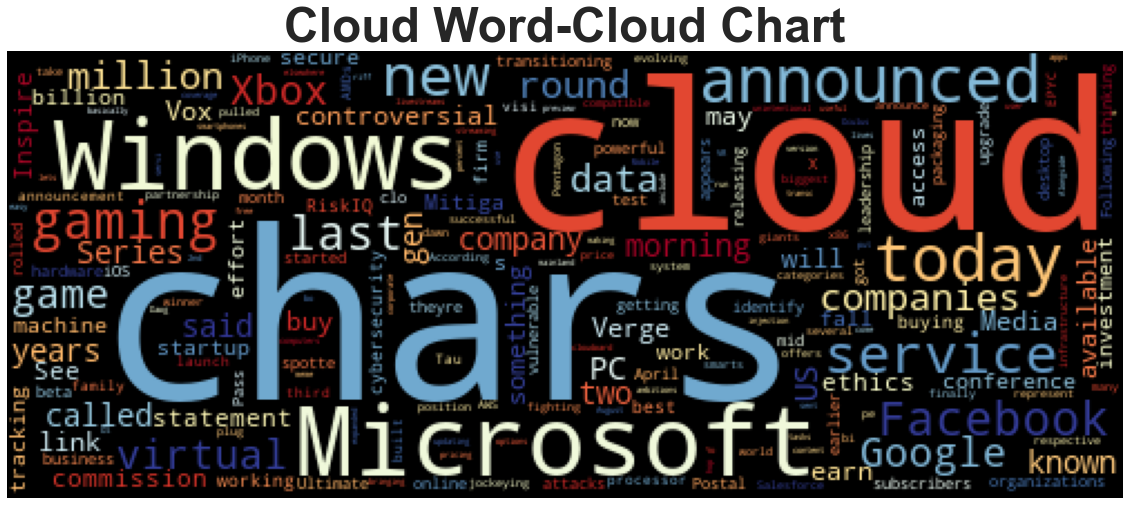

In [16]:
wordcloud(cloud.text.str.cat(), title = "Cloud Word-Cloud Chart")

In [17]:
import spacy
from spacy import displacy

In [18]:
nlp = spacy.load('en_core_web_sm')

In [20]:
cloud_txt = cloud.text.str.cat()
print(cloud_txt)

Microsoft is buying RiskIQ
, a cybersecurity firm best known for working with organizations like Facebook and the US Postal Service to identify where and how theyre vulnerable to online attacks. The… [+883 chars]Microsoft leadership said earlier this month that it was transitioning Xbox Cloud Gaming to more powerful Xbox Series X hardware, and now it appears that some games are getting the upgrade. As spotte… [+1022 chars]When Microsoft announced that it was releasing a cloud PC service called Windows 365 this morning, it got me thinking. While Windows 365 is about packaging a virtual Windows business desktop in a clo… [+4592 chars]Following a beta test that started in mid-April, Microsoft has rolled out its Xbox Cloud Gaming service to all Game Pass Ultimate
 subscribers on iOS and PC. With todays announcement
, you can visi… [+1124 chars]Google this morning announced the launch of Tau, a new family of virtual machines built on AMDs third-gen EPYC processor. According to the company, 

In [21]:
# Run NER processor on all of the text, then store in doc object
doc = nlp(cloud_txt)

# this adds a title to the chart
doc.user_data['title'] = "Cloud NER"

# display 
displacy.render(doc,style='ent',jupyter=True)

In [23]:
for i in doc.ents:
    print(i.text, i.label_)

Microsoft ORG
the US Postal Service ORG
earlier this month DATE
Xbox Cloud Gaming PERSON
Microsoft ORG
Windows PRODUCT
this morning TIME
mid-April DATE
Microsoft ORG
Xbox Cloud Gaming PERSON
this morning TIME
Tau ORG
third ORDINAL
42% PERCENT
two CARDINAL
the last few years DATE
two CARDINAL
Today DATE
Pentagon ORG
10 MONEY
iPhone ORG
August 2nd DATE
Verge ORG
Vox Media ORG
Microsoft ORG
Windows PRODUCT
Today DATE
98 percent PERCENT
US GPE
365 CARDINAL
today DATE
Microsoft Inspire ORG
Microsoft ORG
Windows PRODUCT
Windows PRODUCT
365 CARDINAL
today DATE
Microsoft Inspire ORG
today DATE
Ubisoft GPE
Ini PERSON
MX PRODUCT
Verge ORG
Vox Media ORG
Photo PERSON
Cameron Faulkner PERSON
Berkely’s RISELabs ORG
$9.5 million MONEY
today DATE
Secure Access Service Edge ORG
Friday DATE
$300 million MONEY
$7.5 billion MONEY
Google’s ORG
120 CARDINAL
AirTable ORG
Today DATE
Mitiga PERSON
$25 million MONEY
Mitiga PERSON
Worobey PERSON
first ORDINAL
chars]The Department of Defense ORG
$10 billion MONEY